<a href="https://colab.research.google.com/github/shaungpaung/car_brand_img_model_classification/blob/main/car_brand_img_model_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install pyspark

In [ ]:
from pyspark import __version__ as spark_version

print("PySpark version:", spark_version)


PySpark version: 3.5.2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = [224, 224]
TrainFolder = '/content/drive/MyDrive/Car_Brand_Logos/Train'
ValidationFolder = '/content/drive/MyDrive/Car_Brand_Logos/Test'
myResnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# Freeze the pre-trained layers
for layer in myResnet.layers:
    layer.trainable = False

# Get the number of classes
Classes = glob(TrainFolder + '/*')
classesNum = len(Classes)

In [ ]:
PlusFlattenlayer = Flatten()(myResnet.output)
prediction = Dense(classesNum, activation='softmax')(PlusFlattenlayer)
model = Model(inputs=myResnet.input, outputs=prediction)

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale the validation set
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load the training and validation datasets
training_set = train_datagen.flow_from_directory(
    TrainFolder,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    ValidationFolder,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

Found 2513 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 865s 10s/step - accuracy: 0.3313 - loss: 2.7164 - val_accuracy: 0.5000 - val_loss: 1.6767
Epoch 2/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 6:55 5s/step - accuracy: 0.5312 - loss: 1.6979

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5312 - loss: 1.6979 - val_accuracy: 0.4375 - val_loss: 2.2686
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 501s 6s/step - accuracy: 0.4439 - loss: 1.9485 - val_accuracy: 0.5339 - val_loss: 1.6326
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5938 - loss: 1.0212 - val_accuracy: 0.5625 - val_loss: 2.4041
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 504s 6s/step - accuracy: 0.5256 - loss: 1.5177 - val_accuracy: 0.4193 - val_loss: 2.8244
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4688 - loss: 1.6443 - val_accuracy: 0.5625 - val_loss: 2.5608
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 495s 6s/step - accuracy: 0.4748 - loss: 1.9730 - val_accuracy: 0.4948 - val_loss: 1.9552
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5938 - loss: 1.3002 - val_accuracy: 0.4375 - val_loss: 2.8788
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 493s 6s/step - accuracy: 0.5906 - loss: 1.3983 - val_accuracy: 0.5339 - val_loss: 2.

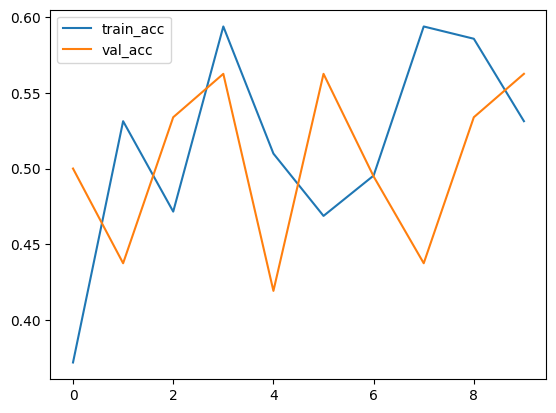

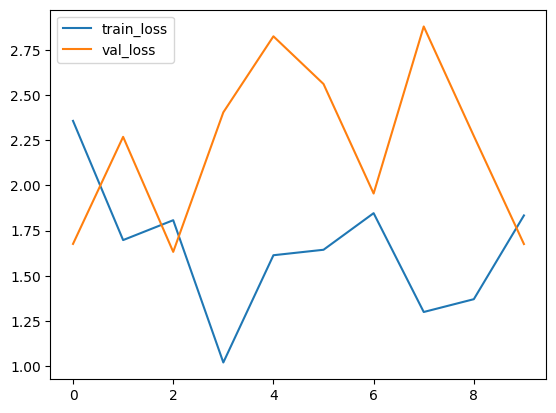

In [ ]:
# Calculate steps per epoch
steps_per_epoch = training_set.samples // training_set.batch_size
validation_steps = test_set.samples // test_set.batch_size

# Train the model
result = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# Plot accuracy
plt.plot(result.history['accuracy'], label='train_acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Plot loss
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Save the trained model
model.save('/content/drive/MyDrive/Car_Brand_Logos/myCarsModel.h5')

Evaluate the Model on the Validation (Test) Set

In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.5344 - loss: 2.1588
Test Accuracy: 51.00%
Test Loss: 2.1565


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/MyDrive/Car_Brand_Logos/mazda.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Rescale the image

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: 6


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/MyDrive/Car_Brand_Logos/test-log.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

class_labels = list(training_set.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]
print(f'Predicted logo: {predicted_class_name}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted logo: mazda


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/MyDrive/Car_Brand_Logos/test_logo_2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

class_labels = list(training_set.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]
print(f'Predicted logo: {predicted_class_name}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Predicted logo: mercedes
